In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import binary_opening, disk, label
from skimage.measure import label, regionprops
import tensorflow as tf
import seaborn as sns
import cv2

In [1]:
BASE_DIR = '../data/airbus-ship-detection'
path_train = BASE_DIR + '/train_v2/'
path_test = BASE_DIR + '/test_v2/'

In [2]:
df = pd.read_csv(os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv'))

NameError: name 'pd' is not defined

In [27]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


The train_ship_segmentations_v2.csv contains the run-length encoded bounding boxes for the ships in the train/ directory.
- This dataframe has two columns: ImageId and EncodedPixels
- ImageId contains the name of the image file
- EncodedPixels contains the mask of the ship on the image. For working with them we are using helping functions.
- An image with more than one ship will have n rows in this csv, one for each ship
- If the image has no ships, the EncodedPixels column has the value NaN


In [13]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

# Plot some images

In [14]:
images_with_ship = df.ImageId[df.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 42556 image files with masks


Image 000155de5.jpg
Found bbox (465, 344, 501, 448)


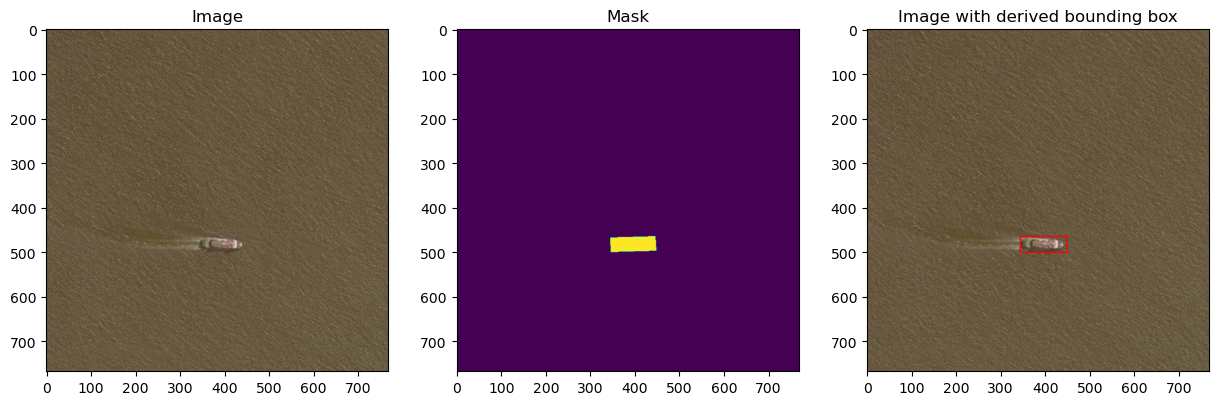

Image 000194a2d.jpg
Found bbox (174, 258, 185, 306)
Found bbox (178, 331, 197, 370)
Found bbox (287, 469, 307, 492)
Found bbox (377, 67, 387, 85)


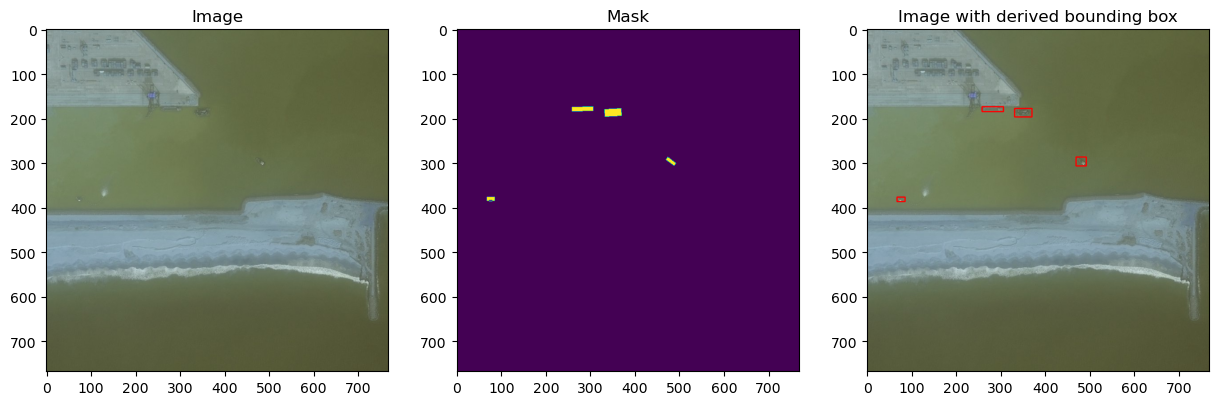

Image 00021ddc3.jpg
Found bbox (629, 181, 638, 187)
Found bbox (661, 195, 665, 201)
Found bbox (705, 96, 720, 121)
Found bbox (732, 123, 768, 178)


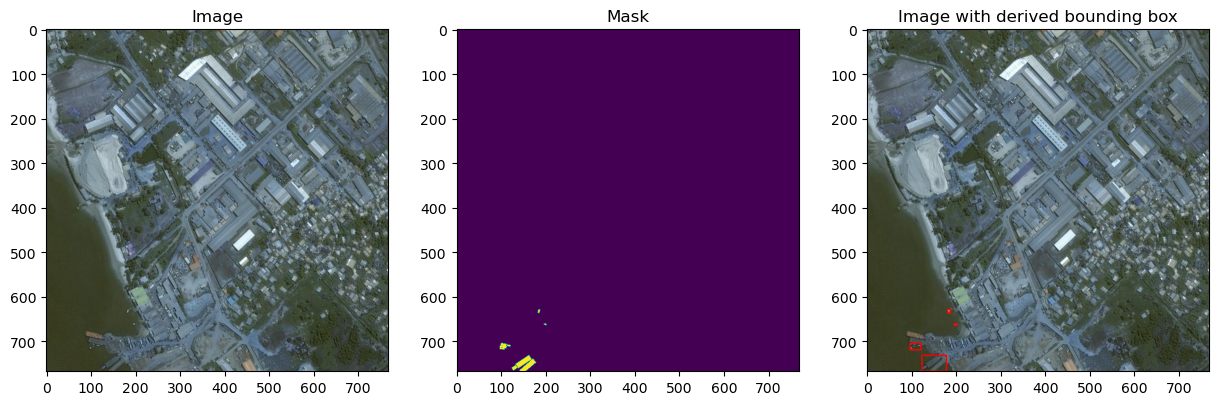

Image 0002756f7.jpg
Found bbox (36, 324, 67, 351)


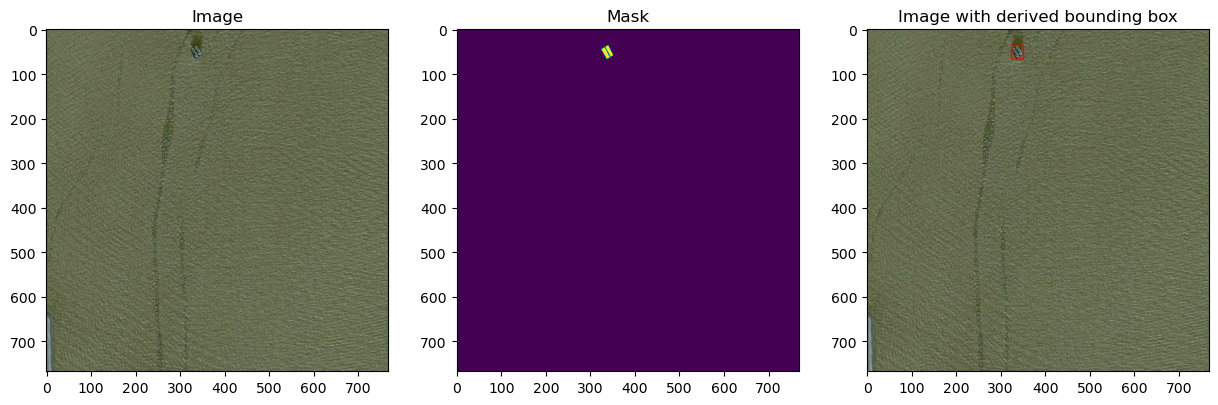

Image 00031f145.jpg
Found bbox (124, 443, 153, 472)


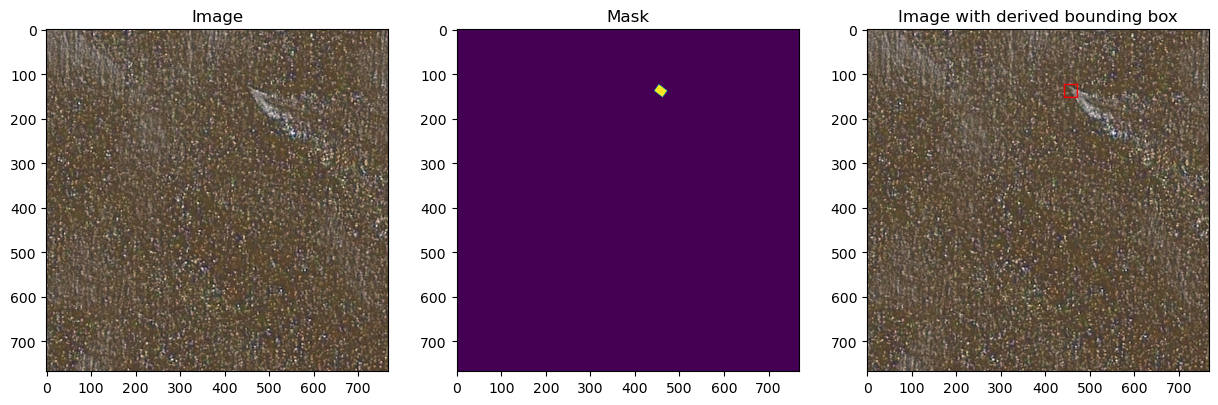

In [16]:
for i in range(5):
    image = images_with_ship[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(path_train + image)
    rle_0 = df.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0)
    ax3.imshow(img_1)
    plt.show()

# Data analysis

In [23]:
df['HasShip'] = df['EncodedPixels'].notnull()
grouped_df = df.groupby("ImageId").agg({'HasShip': ['first', 'sum']}) # counts amount of ships per image, sets ImageId to index
grouped_df.columns = ['HasShip', 'TotalShips']

Images: 192556 
Ships:  81723
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)


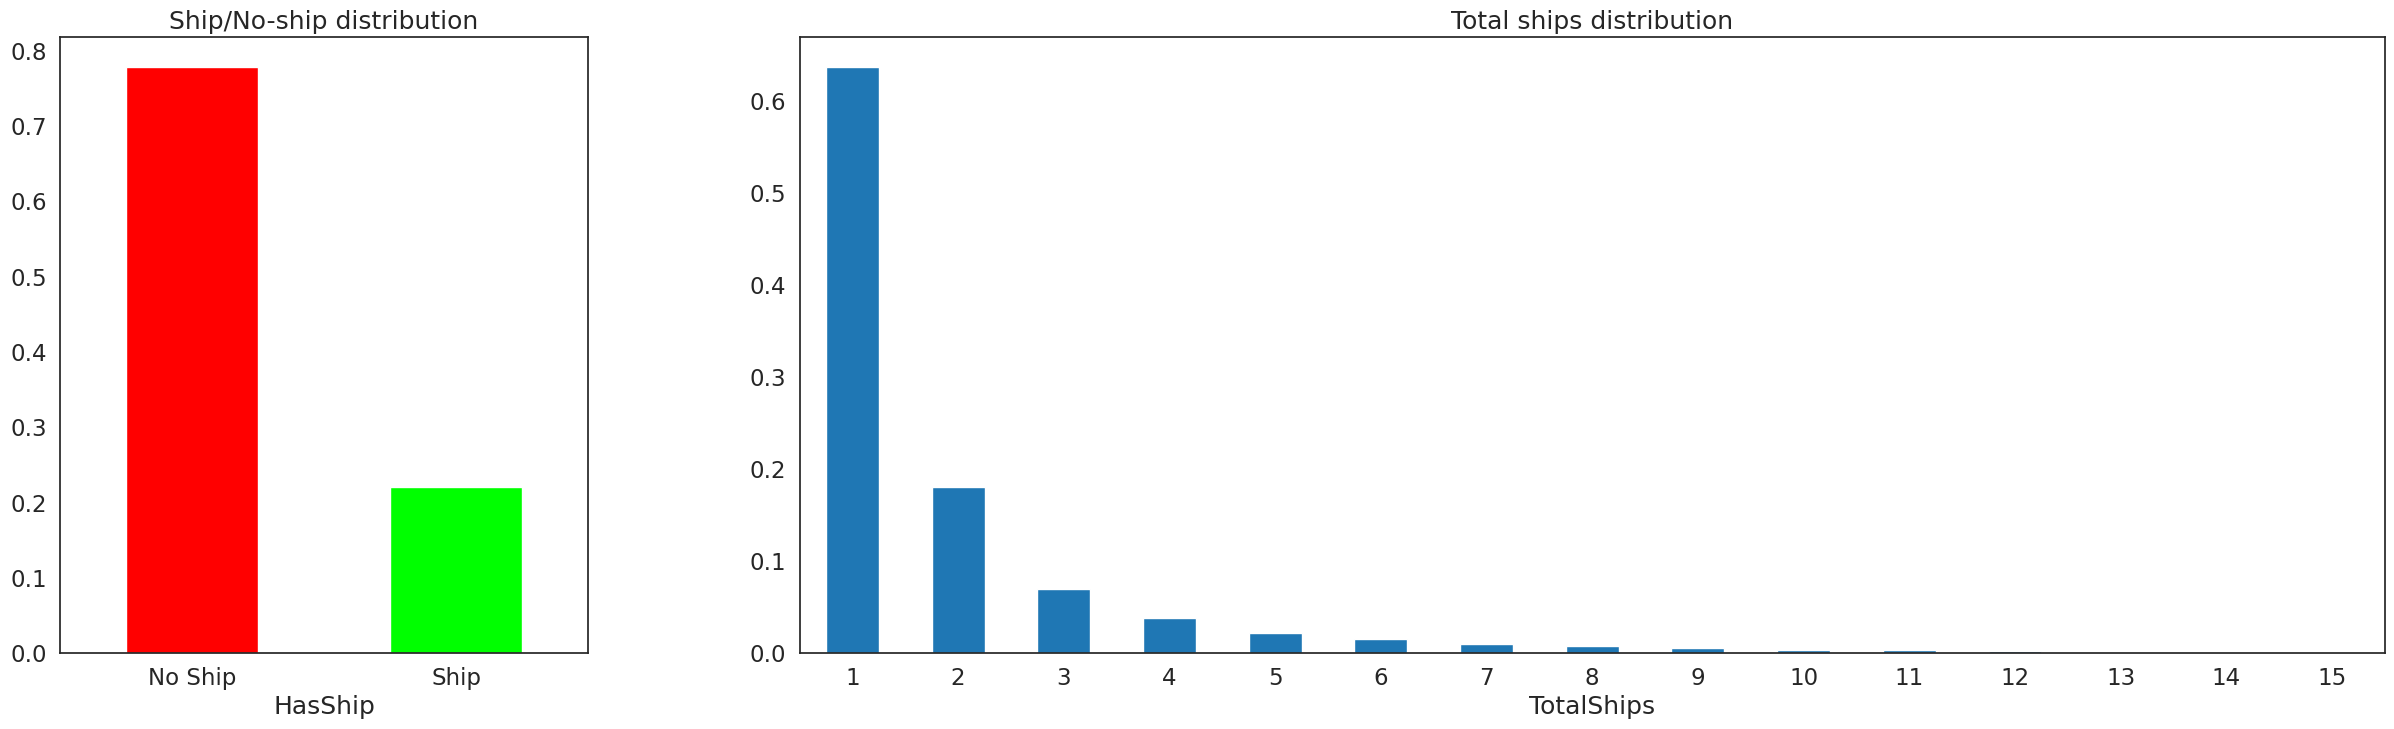

In [24]:
total = len(grouped_df)
ship = grouped_df['HasShip'].sum()
no_ship = total - ship
total_ships = int(grouped_df['TotalShips'].sum())

print(f"Images: {total} \nShips:  {total_ships}")
print(f"Images with ships:    {round(ship/total,2)} ({ship})")
print(f"Images with no ships: {round(no_ship/total,2)} ({no_ship})")

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 8), gridspec_kw = {'width_ratios':[1, 3]})

# Plot ship/no-ship with a bar plot
ship_ratio = grouped_df['HasShip'].value_counts() / total
ship_ratio = ship_ratio.rename(index={True: 'Ship', False: 'No Ship'})
ship_ratio.plot.bar(ax=axes[0], color=['red', 'lime'], rot=0, title="Ship/No-ship distribution");

# Plot TotalShips distribution with a bar plot
total_ships_distribution = grouped_df.loc[grouped_df['HasShip'], 'TotalShips'].value_counts().sort_index() / ship
total_ships_distribution.plot(kind='bar', ax=axes[1], rot=0, title="Total ships distribution");

*As we can see, the data is not balanced - images without ships are far more than images with ships. So, the thing that we could try to improve the result of our model, is taking the less amount of images without ships to make our dataset more balanced.*